In [20]:
%matplotlib inline
import cv2
import numpy as np
from scipy.signal import convolve2d
from scipy.ndimage.filters import correlate 
import matplotlib.pyplot as plt
import matplotlib.image as pltimg 
from scipy.ndimage.filters import gaussian_laplace
from scipy.ndimage.filters import gaussian_filter

from scipy.ndimage.filters import maximum_filter
from skimage.feature import peak_local_max
from skimage.transform import resize
import math

In [3]:
def load_image(path):
    '''
    :param path: path to load image
    :return: grayscaled and float image
    '''
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # transmit the image to float
    img = img.astype(np.float64)/255.0

    print(img.shape)
    return img

In [4]:
def normalize(img):
    ''' Function to normalize an input array to 0-1 '''
    img_min = img.min()
    img_max = img.max()
    return (img - img_min) / (img_max - img_min)

def generate_laplacian_filter(size, sigma):
    return gaussian_laplace(np.zeros((size,size)),sigma=sigma)

In [5]:
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    
    for i in range(len(cx)):
        circ = Circle((cx[i], cy[i]), rad[i], color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

In [6]:

def blob_detector(img, sigma, k, levels, threshold, method):
    sigma = float(sigma)
    initial_sigma = sigma
    height, width = img.shape
    
    # Increase the filter size method
    if method == 'upscale':
        print("using upscale method!")
        img_scale_space = np.zeros((height, width, levels), dtype=np.float64)
        for i in range(levels):
            img_scale_space[:, :, i] = np.power(gaussian_laplace(img, sigma=sigma) * sigma**2, 2)
            sigma = sigma * k
            
    elif method == "downsample":
        print("using downsample method!")
        # TODO: add to report: filter size shall be odd
        img_scale_space = np.zeros((height, width, levels), dtype=np.float64)
        for i in range(levels):
            new_shape = (int(height * (1.0/np.power(k, i))),int(width* (1.0/np.power(k, i))))
            img_small = resize(img, new_shape)
            # print("at level %d, img_small size =%s" % (i, str(img_small.shape)))
            # temp = np.absolute(gaussian_laplace(img_copyed, sigma=sigma) * sigma**2)
            img_tmp = np.power(gaussian_laplace(img_small, sigma=sigma, truncate=0.8), 2)
            #use int to indicate new size
            img_scale_space[:, :, i] = resize(img_tmp, img.shape) 
            #use fraction of current size
            
    print("scaled image space generated!")
    
    
    '''
        Non maximum supression:
            1.first: maximum filter the image
            2.check if a position is largest
            3.filtered out non_maxmum position in img
    '''
    max_filterd_space = np.zeros(img_scale_space.shape, dtype=np.float64)

    for i in range(levels):
        max_filterd_space[:, :, i] = maximum_filter(img_scale_space[:, :, i], size=(3, 3))
       
    maxima_space = np.zeros((height, width), dtype=np.float64)
    # along with level max value
    maxima_space = np.max(max_filterd_space, axis=2)

    survive_space = np.zeros(img_scale_space.shape, dtype=np.float64)
    # locating survive pos

    for i in range(levels):
        boolean_space = (maxima_space == img_scale_space[:, :, i])
        survive_space[:, :, i] = boolean_space * img
    
    print("begin drawing circles!")

    cx = []
    cy = []
    radius = []
    for i in range(levels):
        location = np.argwhere(survive_space[:, :, i] >= threshold)
        # in higher scale have larger radius
        rad = np.sqrt(2) * initial_sigma * np.power(k, i)
        cx = cx + [x[0] for x in location]
        cy = cy + [x[1] for x in location]
        radius = radius + [rad]*len(location)
        # print("At level %d, possible  %d circles, actual %d circles" % (np.count_nonzero(survive_space[:, :, i]),i, len(location)))
        
    # with open("coor.txt","w") as fp:
    #     pos = zip(cx,cy,radius)
    #     fp.write(str([x for x in pos]))
    
    print("circle numebrs %d" %(len(cx)))
    
    # !!! Attention, cx and cy are reversed
    show_all_circles(img, cy, cx, radius)


In [7]:

BUTTERFLY = "data\\part2\\butterfly.jpg" 
EINSTEIN = "data\\part2\\einstein.jpg"
FISHES = "data\\part2\\fishes.jpg"
SUNFLOWERS =  "data\\part2\\sunflowers.jpg"

(357, 328)
using upscale method!


scaled image space generated!
begin drawing circles!


circle numebrs 959


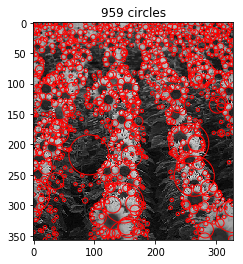

In [10]:
# upscaling parameters
'''
k           increasing factor K
levels      number of iterations
'''
threshold = 0.25
k = 1.25   
levels = 12                   
sigma = 2

img = load_image(SUNFLOWERS)
blob_detector(img, sigma, k, levels, threshold, method = 'upscale')

using downsample method!
scaled image space generated!


C:\Users\bluerain\PycharmProjects\cvmp2\new_venv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\bluerain\PycharmProjects\cvmp2\new_venv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


begin drawing circles!
circle numebrs 1180


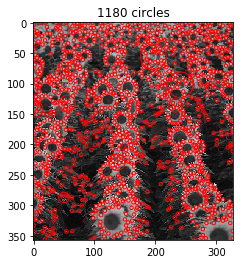

In [11]:
# img = load_image(EINSTEIN)
threshold = 0.25
k = 1.25
levels = 12                   
sigma = 2
blob_detector(img, sigma, k, levels, threshold, method = 'downsample')

In [14]:
#define DOG
def generate_gaussian_kernel(rows, cols, sigma, highPass=True):
    '''
    :param rows: rows of gaussian kernel
    :param cols: cols of gaussian kernel
    :param sigma: sigma
    :param highPass: if this kernel is in highpass mode
    :return: 
    '''
    center_row = int(rows/2) + 1 if rows % 2 == 1 else int(rows/2)
    center_col = int(cols/2) + 1 if cols % 2 == 1 else int(cols/2)
    def gaussian_at_pos(i,j):  
        coefficient = np.exp(-1.0 * ((i - center_row)**2 + (j - center_col)**2) / (2 * sigma**2))
        return 1 - coefficient if highPass else coefficient
    
    return np.array([[gaussian_at_pos(i, j) for j in range(cols)] for i in range(rows)])



def dog_method(img, threshold, k, levels, octave, sigma):
    sigma = float(sigma)
    initial_sigma = sigma
    height, width = img.shape
    
    for oct in range(0,octave*2+1,2):
        print("current oct %d" %(oct))
        sigma = initial_sigma * np.power(k, 2*oct)
        if oct == 0:
            new_shape = img.shape
        else:
            new_shape = (int(height/oct), int(width/oct))
        cur_octave = resize(img, new_shape)
        img_scale_space_tmp = np.zeros((*new_shape, levels))
        
        for i in range(levels):
            img_scale_space_tmp[:, :, i] = (correlate(cur_octave, 
                                                      generate_gaussian_kernel(3, 3, sigma)) ** 2)
            if oct != 0:
                img_scale_space_tmp[:, :, i] *= (np.power(sigma, 2))
            sigma *= k
        
        # img_scale_space height*width*levels-1
        img_scale_space = np.zeros((*new_shape, levels-1))
        for i in range(1, levels):
            img_scale_space[:, :, i-1] = img_scale_space_tmp[:, :, i] - img_scale_space_tmp[:, :, i-1]
        if oct == 0:
            scale_space_1 = img_scale_space
        if oct == 2:
            scale_space_2 = img_scale_space
        if oct == 4:
            scale_space_3 = img_scale_space
        
       
    scale_space_origin_1 = scale_space_1
    scale_space_origin_2 = np.zeros((scale_space_origin_1.shape))
    scale_space_origin_3 = np.zeros((scale_space_origin_1.shape))
    # Scale_space resize to oringinal image
    for i in range(scale_space_origin_1.shape[2]):
        scale_space_origin_2[:, :, i] = resize(scale_space_2[:,:,i], img.shape)
        scale_space_origin_3[:, :, i] = resize(scale_space_3[:,:,i], img.shape)
    

    # diff space size: height * width * octave * octave
    diff_space = np.stack((scale_space_origin_1, scale_space_origin_2, scale_space_origin_3), axis=2)
    # to height*width*(octave^2)
    diff_space = diff_space.reshape((*img.shape, -1))
    print("diff space size:", diff_space.shape)
    print(np.count_nonzero(diff_space))
    
    # for i in range(diff_space.shape[2]):
    #     maxmum_diff_space = maximum_filter(diff_space[:, :, i], size=(3,3))
    #     tmp = diff_space[:, :, i] * (maxmum_diff_space == diff_space[:, :, i])
    #     tmp[tmp < threshold] = 0
    #     diff_space[:, :, i] = tmp
    #     
    #     
    # print(np.count_nonzero(diff_space))
    # 
    
    max_filterd_space = np.zeros(diff_space.shape, dtype=np.float64)

    for i in range(diff_space.shape[2]):
        max_filterd_space[:, :, i] = maximum_filter(diff_space[:, :, i], size=(3, 3))
       


    survival_space = np.zeros(diff_space.shape, dtype=np.float64)
    # locating survive pos
    # maximum_space = np.argmax(max_filterd_space, axis=2)

    for i in range(diff_space.shape[2]):
        # boolean_space = (maximum_space == diff_space[:, :, i])
        
        boolean_space = (max_filterd_space[:, :, i] == diff_space[:, :, i])
        survival_space[:, :, i] = boolean_space * img
    
  
    print("begin drawing circles!")
    print(survival_space.shape)
    cx = []
    cy = []
    radius = []
    for i in range(survival_space.shape[2]):
        location = np.argwhere(survival_space[:, :, i] > threshold)
        rad = initial_sigma 
        if i < 3:
            rad *= np.power(np.sqrt(2), i) 
        elif i < 6:
            rad *=  np.power(np.sqrt(2), i-3) * np.sqrt(2)
        else:
            rad *= np.power(np.sqrt(2), i-6) * 2
        # rad = np.sqrt(2) * initial_sigma * np.power(k, i)
       
        cx = cx + [x[0] for x in location]
        cy = cy + [x[1] for x in location]
        radius = radius + [rad]*len(location)
        print("At level %d, possible  %d circles, actual %d circles" % (i,np.count_nonzero(survival_space[:, :, i]), len(location)))
        
    # with open("coor.txt","w") as fp:
    #     pos = zip(cx,cy,radius)
    #     fp.write(str([x for x in pos]))
    
    print("circle numebrs %d" %(len(cx)))
    
    # !!! Attention, cx and cy are reversed
    show_all_circles(img, cy, cx, radius)

current oct 0
current oct 2
current oct 4
current oct 6
diff space size: (357, 328, 9)
1053864
begin drawing circles!
(357, 328, 9)
At level 0, possible  3180 circles, actual 685 circles
At level 1, possible  3262 circles, actual 718 circles
At level 2, possible  3345 circles, actual 753 circles
At level 3, possible  1094 circles, actual 322 circles
At level 4, possible  1097 circles, actual 325 circles
At level 5, possible  1101 circles, actual 326 circles
At level 6, possible  492 circles, actual 204 circles
At level 7, possible  492 circles, actual 204 circles
At level 8, possible  492 circles, actual 204 circles
circle numebrs 3741


C:\Users\bluerain\PycharmProjects\cvmp2\new_venv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\bluerain\PycharmProjects\cvmp2\new_venv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


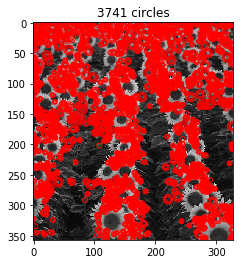

In [16]:
# Extra credit:DOG method
threshold = 0.25
k = np.sqrt(2)
levels = 4
octave = 3
sigma = 2
dog_method(img,threshold,k,levels,octave,sigma)

In [53]:
def show_ellipse_circles(img, cx, cy, rad1, rad2, color = 'r'):
    import matplotlib.pyplot as plt
    from matplotlib.patches import Ellipse
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(img, cmap='gray')
    
    for x,y,width,height in zip(cx, cy, rad1, rad2):
        ellip = Ellipse((x, y), width=width, height = height, color=color, fill=False)
        ax.add_patch(ellip)

    
    plt.title('%i ellipse' % len(cx))
    plt.show()
    pass

In [77]:
# extra credit: affine_transf
dx = np.array([
        [-1,0,1],
        [-1,0,1],
        [-1,0,1]
    ])
dy = np.array([
    [-1,-1,-1],
    [0,0,0],
    [1,1,1]
])
from numpy.linalg import eig
def affine_transform_method(img, threshold,  sigma):
    sigma = float(sigma)
    height, width = img.shape
    initial_sigma = sigma
    Ix = correlate(img, dx)
    Iy = correlate(img, dy)
    # gaussian_filter = generate_gaussian_kernel(int(6*sigma),int(6*sigma),sigma)
    Ix2 = gaussian_filter(Ix**2, sigma=sigma)
    Iy2 = gaussian_filter(Iy**2, sigma=sigma)
    Ixy = gaussian_filter(Ix*Iy, sigma=sigma)
    
    scale_space = np.absolute(gaussian_laplace(img, sigma=sigma)* np.power(sigma,2))
    max_space  = maximum_filter(scale_space, size=(3,3))
    
    boolean_space = scale_space == max_space
    survive_space = img * boolean_space
    
    #Compute second moment matrix 
    rad_l = np.zeros(img.shape)
    rad_s = np.zeros(img.shape)
    
    for i in range(height):
        for j in range(width):
            tmp = np.zeros((2, 2))
            tmp[0, 0], tmp[0, 1], tmp[1, 0], tmp[1, 1] = Ix[i,j],Ixy[i,j],Ixy[i,j],Iy2[i,j]
            eigen_values, _ = eig(tmp)
            eigen_values = np.absolute(eigen_values)
            rad_l[i,j] = max(eigen_values)
            rad_s[i,j] = min(eigen_values)
            
    cx = []
    cy = []
    radius1 = []
    radius2 = []
    for i in range(height):
        for j in range(width):
            if survive_space[i, j] > threshold: 
                cx += [i]
                cy += [j]
                radius1 += [rad_l [i, j] * sigma * 10]
                radius2 += [rad_s [i, j] * sigma * 10] 
    
    # radius 1 is larger
    print(np.average(radius2))
    print(np.average(radius1))
    print("total %d ellipse" % (len(cx)))
    show_ellipse_circles(img, cy, cx, radius2, radius1)


(356, 493)


1.0728384115715448
4.6549378224076285
total 3088 ellipse


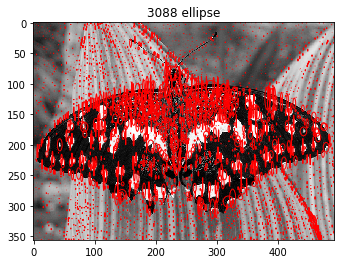

In [78]:
threshold = 0.15
sigma = 2
img = load_image(BUTTERFLY)
affine_transform_method(img, threshold, sigma)